<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/current_skin_cancer_bt_pretrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer BT

- The purposes of this notebook is to establish some baselines on the following:

    - 

## Let's look at how pre-trained networks do, meaning pretrained on ImageNet the supervised way...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/archive (1).zip"

Archive:  /content/drive/My Drive/archive (1).zip
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024763.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024771.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024800.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024913.jpg  
  inflating: skin_cancer_ISIC/Test/actinic keratosis/ISIC_0024948.jpg  
  inflating: s

## Install MONAI, updata fastai, any other installs go here

In [ ]:
#try installing as with !pip install -qU

#!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"
!pip install -qU "monai-weekly[gdown, nibabel, tqdm, itk]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 MB 29.8 MB/s eta 0:00:00


In [ ]:
#pip install fastai==2#.7.1

In [ ]:
#Other installs here
!pip install -qU git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.1 MB/s eta 0:00:00


## Imports

In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
#print_config()

In [ ]:
import fastai
from fastai.vision.all import *
#Other imports here

from base_rbt.base_model import * 
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import pickle
from statistics import mean
from statistics import stdev
import itertools
import inspect



fastai.__version__

'2.7.10'

## Read image filenames from the dataset folders

In [ ]:
#kaggle
train_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Train'
test_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Test'

In [ ]:
#colab
train_dir='skin_cancer_ISIC/Train'
test_dir='skin_cancer_ISIC/Test'

In [ ]:
#train
class_names0 = os.listdir(train_dir)
class_names = sorted(class_names0)
num_class = len(class_names)
image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

## Now get the training data and validation data etc

In [ ]:
#Helper functions to extract class names from the filenames
import re
def extract_text(string):
    # Use the compile method to create a RegexObject
    pattern = re.compile(r'/Train/(.*?)/ISIC')

    # Use the search method of the RegexObject to find the pattern in the string
    match = pattern.search(string)

    # If a match is found, return the matched text
    if match:
        return match.group(1)
    # If no match is found, return None
    else:
        
        return None

def label_func(x): return extract_text(x.as_posix())

#files names
fnames = get_image_files(train_dir)

#Extract training set
max_num =100 #maximum number of samples in each class
count_dict = {i:0 for i in class_names}
fnames_train = []
for i in fnames:
    #st=extract_text(i.as_posix())
    st=label_func(i)
    
    if count_dict[st]<max_num: #no more than 100 samples per category
        fnames_train.append(i)
        count_dict[st]+=1
                
#We further partition fnames_train into a tune-valiation set
count_dict2 = {i:0 for i in class_names}
fnames_tune = []
for i in fnames_train:
    st = label_func(i)
    if count_dict2[st] < 0.8*count_dict[st]:
        fnames_tune.append(i)
        count_dict2[st]+=1
        
def get_difference(x1, x2):
    return list(set(x1) - set(x2))

fnames_valid = get_difference(fnames_train,fnames_tune)

fnames_test = get_difference(fnames,fnames_train) + get_image_files(test_dir)

#sanity check
def display_dict(_fnames):
    
    _labels = [label_func(i) for i in _fnames]
    tem_dict = {i:_labels.count(i) for i in _labels}
    return tem_dict

tem_dict = display_dict(fnames)
print(f'The "original" training set: \n {tem_dict}\n')

tem_dict = display_dict(fnames_train)
print(f'Training set: used to train BT etc i.e. viewed as unlabelled \n {tem_dict}\n')

print('The training set is partitioned into tune-valid sets, with ~ 80-20 split\n')

tem_dict = display_dict(fnames_tune)
print(f'Tune set: used to train classifiers on representations \n {tem_dict}\n')

tem_dict = display_dict(fnames_valid)
print(f'Valid set: used to validate the classifiers trained above \n {tem_dict}\n')

tem_dict = display_dict(fnames_test)
print(f'Test set: only examine at the very end {tem_dict}\n')


The "original" training set: 
 {'squamous cell carcinoma': 181, 'vascular lesion': 139, 'actinic keratosis': 114, 'melanoma': 438, 'pigmented benign keratosis': 462, 'dermatofibroma': 95, 'seborrheic keratosis': 77, 'nevus': 357, 'basal cell carcinoma': 376}

Training set: used to train BT etc i.e. viewed as unlabelled 
 {'squamous cell carcinoma': 100, 'vascular lesion': 100, 'actinic keratosis': 100, 'melanoma': 100, 'pigmented benign keratosis': 100, 'dermatofibroma': 95, 'seborrheic keratosis': 77, 'nevus': 100, 'basal cell carcinoma': 100}

The training set is partitioned into tune-valid sets, with ~ 80-20 split

Tune set: used to train classifiers on representations 
 {'squamous cell carcinoma': 80, 'vascular lesion': 80, 'actinic keratosis': 80, 'melanoma': 80, 'pigmented benign keratosis': 80, 'dermatofibroma': 76, 'seborrheic keratosis': 62, 'nevus': 80, 'basal cell carcinoma': 80}

Valid set: used to validate the classifiers trained above 
 {'seborrheic keratosis': 15, 'derma

## Hyperparameters

In [ ]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

###################
#batch sizes, number of epochs (for training BT and for fine tuning)

bs=256
bs_tune = 256
bs_val = len(fnames_valid)
size=128
n_in=3
numfit=200
num_epochs=200
ps=4096
###################

###################
#Hyperparams for BT augmentations
#ImageNet style augmentations (see BYOL paper)
flip_p1 = 0.5
flip_p2 = 0.5

jitter_p1 = 0.8
jitter_p2 = 0.8

bw_p1 = 0.2
bw_p2 = 0.2

blur_p1 = 1.0
blur_p2 = 0.1

sol_p1 = 0.0
sol_p2 = 0.2

noise_p1 = 0.0
noise_p2 = 0.0
#Noise isn't included! So we exclude for now

#Normalization?? None for now as it looks weird

resize_scale=(0.7, 1.0)
resize_ratio=(3/4, 4/3)

#Rotation isn't included in ImageNet. We just include some. 
rotate_deg = 45
rotate_p = 0.5

##Values of hps:
blur_r = (0.1,2) #like BYOL
blur_s = 13 #as ~ 128/10 like BYOL

sol_t = 0.1 #kornia defaults. Not sure still about BYOL defaults.
sol_a = 0.1

noise_std = 0.1 

###################

###################
#Hyperparams for fine-tuning augmentations. We use: blur; jitter; grayscale (maybe) and soft augs.
blur_r_tune = blur_r
blur_s_tune = blur_s
flip_p_tune = 0.25
rotate_p_tune = 0.25
jitter_p_tune = 0.0
bw_p_tune = 0.0
blur_p_tune = 0.0


## Now get the training dataloader and view the data

In [ ]:

device ='cuda' if torch.cuda.is_available() else 'cpu'

item_tfms = [Resize(size)]

dls_train  = ImageDataLoaders.from_path_func(train_dir, fnames_train, label_func,
                                      bs=bs,
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device,
                                      num_workers=12*(device=='cuda')
                                    )
x,y = dls_train.one_batch()

dls_tune = ImageDataLoaders.from_path_func(train_dir, fnames_tune, label_func,
                                      bs=bs_tune,
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device,
                                      shuffle=False,
                                      num_workers=12*(device=='cuda'),
                                    )
xtune,ytune = dls_tune.one_batch()

dls_valid  = ImageDataLoaders.from_path_func(train_dir, fnames_valid, label_func,
                                      bs=bs_val,
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      num_workers=12*(device=='cuda')
                                    )
xval,yval = dls_valid.one_batch()

In [ ]:
#Write tests here
test_eq(x.shape[0],bs)
test_eq(xtune.shape[0],bs_tune)
test_eq(xval.shape[0],bs_val)


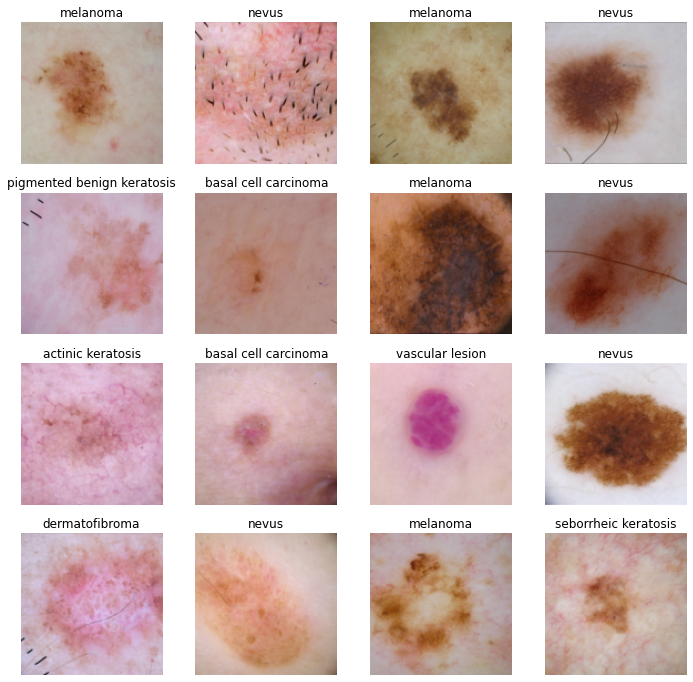

In [ ]:
dls_train.show_batch(max_n=16)

## BT stuff now!

## Plan:

 - Ok, what are the possible directions for our project now? Clearly need to experiment with pre-trained weights... 

 Ok simiplifying: choices for initial weights: 
 - [random,supervised_pretrained, bt_pretrained]
 
 Choice of whether to BT-pretrain (on current unlabelled dataset) or not

 - Each model then fine-tuned on labelled data.

 So there are 6 different models here. Manageable. (Just...)

 - Hypothesis: An ensemble of: (supervised_pretrained, pretrain) and (bt_pretrained,pretrain) might be best.

 - Another option: take a BT pre-trained model, fine tune it on ImageNette, then pre-train again... lots of options here. Those 6 are probably a good start though.

 Then there is a question of which augmentations to use! We have a methodology in place for that. 

 Note that we can save these models, then use for ensembling as well. Hopefully applying my ensemble idea. 

 Note that as long as we save the models, we are ok. 

 We probably need to run some experiments now. 

 Ok, so we found that data augmentation on dls_tune seems to work well! In fact better than using wd. So there is some experimentation that needs to be done there as well.


## Ok, we ran some initial experiments. Now it is time to run some "probing" experiments, that will guide us where to look next. This is to be done in a systematic way: maybe spend 1-3 hours coding (estimate) then the code can run for several hours while I do other things.

We could establish the 6 baselines? (On the validation set). Then can save an experiment with ensembles; and move onto other ideas (e.g. pretraining bt model on other supervised data first). But before doing that, it is better to know which augmentations to use: this is regarding both dls_train and dls_tune.

So:

- dls_train_augs: 
    - Use BYOL style as a base and run the experiments as before (adding noise etc). Do this for the pretrained (BT) network.

- dls_tune_augs:
    - Have: Low blur; High blur; Low jitter; High jitter. Regarding probability. Probably can test this just with the pretrained supervised network

The goal with these experiments is to find a good set of augmentations, via cross-validation. Intuitively, the exact values (e.g. blur 50% of the time vs 75%) shouldn't matter too much. What matters is "high blur vs low blur", etc.

Once we have a good set of augmentations, we can train the 6 baselines. That might take a day. These could possibly even be the final models! Then we can also compare with ensembling them. 





In [ ]:
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

# Augmentations for BT pre-training:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


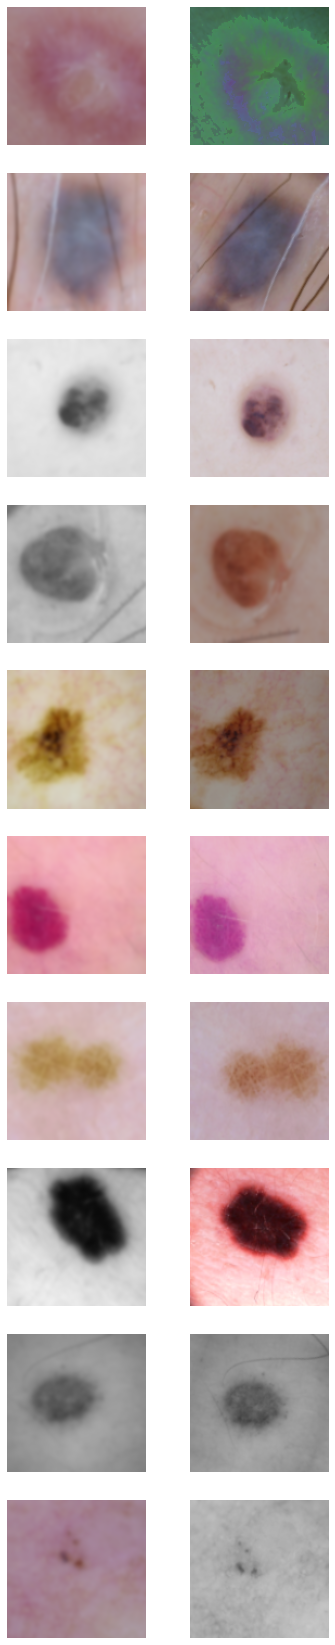

In [ ]:
aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,blur_r=blur_r,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=resize_scale,resize_ratio=resize_ratio,noise_std=noise_std, rotate_deg=rotate_deg,blur_s=blur_s,sol_t=sol_t,sol_a=sol_a, #hps of augs
                    flip_p=flip_p1, rotate_p=rotate_p,noise_p=noise_p1, jitter_p=jitter_p1, bw_p=bw_p1, blur_p=blur_p1,sol_p=sol_p1, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))#,P=0.0)

aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,blur_r=blur_r,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=resize_scale,resize_ratio=resize_ratio,noise_std=noise_std, rotate_deg=rotate_deg,blur_s=blur_s,sol_t=sol_t,sol_a=sol_a, #hps of augs
                    flip_p=flip_p2, rotate_p=rotate_p,noise_p=noise_p2, jitter_p=jitter_p2, bw_p=bw_p2, blur_p=blur_p2,sol_p=sol_p2, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))#,P=0.0)


aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

show_bt_batch(dls=dls_tune,n_in=3,aug=aug_pipelines,n=10,print_augs=True)

## Augmentations for fine tuning

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: 


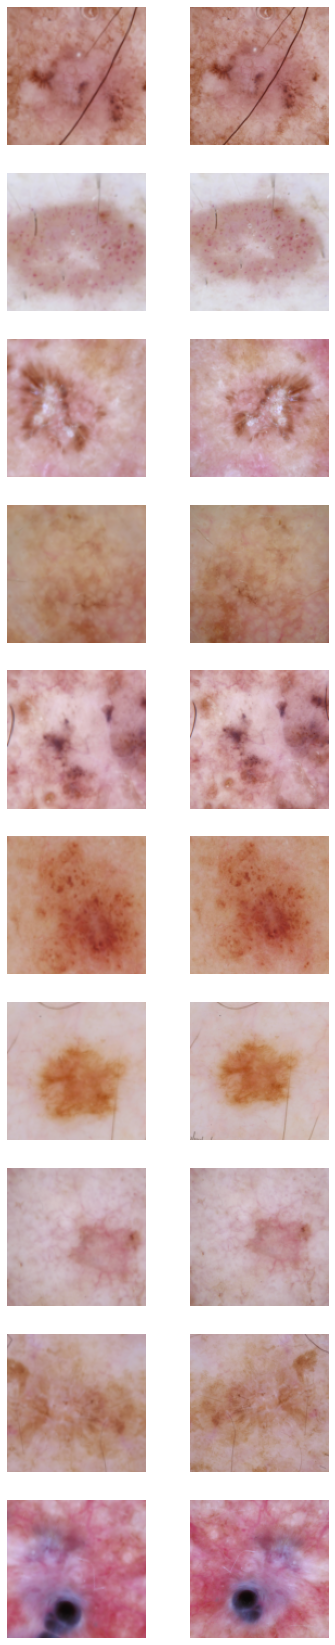

In [ ]:
aug_pipelines_tune =  [get_barlow_twins_aug_pipelines(size=size,blur_r=blur_r_tune,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=resize_scale,resize_ratio=resize_ratio,noise_std=None, rotate_deg=rotate_deg,blur_s=blur_s_tune,sol_t=None,sol_a=None, #hps of augs
                    flip_p=flip_p_tune, rotate_p=rotate_p_tune,noise_p=0.0, jitter_p=jitter_p_tune, bw_p=bw_p_tune, blur_p=blur_p_tune,sol_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))]#,P=0.0)

show_linear_batch(dls=dls_tune,n_in=n_in,n=10,aug=aug_pipelines_tune,print_augs=True)

## Train BT

## Load model: bt-pretrained, supervised-pretrained, or random-weights

In [ ]:
def get_resnet_encoder(model):
    model = create_body(model, n_in=n_in, pretrained=False, cut=len(list(model.children()))-1)
    model.add_module('flatten', torch.nn.Flatten())
    return model


def create_model(which_model=None,n_in=3):

    #pretrained=True if 'which_model' in ['bt_pretrain', 'supervised_pretrain'] else False

    if which_model == 'bt_pretrain': model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    
    elif which_model == 'no_pretrain': model = resnet50()

    elif which_model == 'supervised_pretrain': model = resnet50(weights='IMAGENET1K_V2')

    #ignore the 'pretrained=False' argument here. Just means we use the weights above 
    #(which themselves are either pretrained or not)
    encoder = get_resnet_encoder(model)

    model = create_barlow_twins_model(encoder, hidden_size=ps,projection_size=ps,nlayers=3)

    if device == 'cuda':
        model.cuda()
        encoder.cuda()


    return model,encoder


In [ ]:
model,encoder = create_model(which_model='bt_pretrain')

for p in model.parameters():
    print(p.requires_grad)

    test_eq(p.requires_grad,True)


Downloading: "https://github.com/facebookresearch/barlowtwins/zipball/main" to /root/.cache/torch/hub/main.zip
The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
Downloading: "https://dl.fbaipublicfiles.com/barlowtwins/ep1000_bs2048_lrw0.2_lrb0.0048_lambd0.0051/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
#test:
def sum_params(model):

    s=0
    for p in model.parameters():
        s+=p.sum()
    return s.item()

#Test that shape of encoder is 2048
_,e = create_model(which_model='bt_pretrain')
test_eq(e(x).shape[1],2048) 

#Test that pretrained models (encoders) have the same weights each time
_,e = create_model(which_model='bt_pretrain')
test_eq((sum_params(e)-175864.4062)<0.001,True)

_,e = create_model(which_model='supervised_pretrain')
test_eq((sum_params(e)-39438.5078125)<0.001,True)

#Test that non-pretrained model has diff (i.e. random) weights each time
_,e1 = create_model(which_model='no_pretrain')
_,e2 = create_model(which_model='no_pretrain')
test_ne(sum_params(e1),sum_params(e2))


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Train BT model

In [ ]:
def train_encoder(aug_pipelines,initial_weights=None,pretrain=False):

    model_path = f'/content/drive/My Drive/models/baseline_initial_weights={initial_weights}.pth'

    model,encoder = create_model(which_model=initial_weights)
    learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
    if pretrain: 

        learn.fit(num_epochs)
        torch.save(encoder.state_dict(), model_path)

    return encoder



## How to load models we have trained:

In [ ]:
#load models we have trained here 
# model_path = '/content/drive/My Drive/models/baselinebyol.pth'
# new_fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
# new_fastai_encoder.load_state_dict(torch.load(model_path))


## Fine tune and predict

In [ ]:
#Fine tune and predict

@torch.no_grad()
def predict_model(xval,yval,model):
    
    model.eval()

    test_eq(model.encoder.training,False)

    N=xval.shape[0]
    ypred=model(xval)
    ypred = cast(torch.argmax(ypred, dim=1),TensorCategory)
    correct = (ypred == yval)#.type(torch.FloatTensor)

    #correct = (torch.argmax(ypred,dim=1) == yval).type(torch.FloatTensor)
    num_correct = correct.sum()
    accuracy = num_correct/N
    return accuracy.item()

#Please note, I had to edit this from before: was some weird stuff with TensorImage vs TensorCategory. Annoying, but whatever. 


In [ ]:
class LinearModel(Module):
    """Linear model
    """
    def __init__(self,encoder,
                 indim=1024,#dimension of encoder output
                 outdim=10, #number of classes
                ):
        self.encoder=encoder
        self.L = nn.Linear(indim,outdim)
        
        if torch.cuda.is_available():
            self.L.to('cuda')
        
    def forward(self,x):return self.L(self.encoder(x))

In [ ]:
class Main:

    def __init__(self,
                 aug_pipelines,
                 aug_pipelines_tune,
                 initial_weights=None,
                 pretrain=None,
                 fit_policy=None):
                 
                 store_attr()

                 self.encoder_path = f'/content/drive/My Drive/models/baselineencoder_initial_weights={self.initial_weights}_pretrain={self.pretrain}.pth'
                 self.tuned_model_path = f'/content/drive/My Drive/models/baselinefinetuned_initial_weights={self.initial_weights}_pretrain={self.pretrain}.pth'

                self.tune_fit_dict = {'no_pretrain':'fit_one_cycle','supervised_pretrain':'fine_tune','bt_pretrain':'fine_tune'}



    @classmethod
    def Fit(learn):



    def train_encoder(self):

        #Might come up with better ways of naming this guy...

        model,encoder = create_model(which_model=initial_weights)
        if self.pretrain:
            learn = Learner(dls_train,model, cbs=[BarlowTwins(self.aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])

            if self.fit_policy == 'fit_one_cycle':
                learn.fit_one_cycle(num_epochs)

            elif self.fit_policy == 'fit':
                learn.fit(num_epochs)

            elif self.fit_policy == 'fine_tune':
                learn.fine_tune(num_epochs)

            #torch.save(encoder.state_dict(), self.encoder_path)

        self.encoder=encoder

        return encoder

    def fine_tune(self):

        encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)
        model = LinearModel(encoder=self.encoder,indim=2048,outdim=9)
        learn = Learner(dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=n_in)],wd=0.0)

        #random initial weights we use `fit_one_cycle`
        if self.initial_weights == 'no_pretrain':
            learn.fit_one_cycle(numfit) 

        #else either type of pretrained weights we use `fine_tune`
        elif self.initial_weights == 'supervised_pretrain' or  'bt_pretrain':
            learn.fine_tune(numfit)

        else:
            raise Exception('Initial weights not of required form')

        self.acc = predict_model(xval,yval,model) #eventually can have AUC and other metrics in here

        #torch.save(model.state_dict(), self.tuned_model_path)
        return self.acc

    def __call__(self):
        self.train_encoder() #train (or extract) the encoder
        acc = self.fine_tune() #eventually return a whole dictionary of metrics probably
        return acc

if __name__ == '__main__':
    #Can put a loop here: main can be function of: initial_weight; pretrain; aug_pipelines;

    numfit=100
    

    def hp_acc(initial_weights=None,fit_policy=None,numtimes=3):
        "Function from hps to accuracy dictionary. Averaged numtimes"

        acc_dict = {}
        for i in range(numtimes):

            main = Main(initial_weights=initial_weights,
            pretrain=pretrain,
            aug_pipelines=aug_pipelines,
            aug_pipelines_tune=aug_pipelines_tune,
            fit_policy = fit_policy
            )
            
            acc = main()

            acc_dict[i] = acc

            print(f'On run {i}  with initial_weights = {initial_weights} and fit_policy = {fit_policy} we have acc={acc}')

        acc_dict['mean'] = mean(acc_dict.values())

        print(f'Mean peformance over {numtimes} runs:  with initial_weights = {initial_weights} and fit_policy = {fit_policy} we have acc={acc_dict["mean"]}')

        return acc_dict

    pretrain=True
    Initial_Weights = ['no_pretrain','supervised_pretrain','bt_pretrain']
    Fit_Policy = ['fit_one_cycle','fit','fine_tune']

    hps =  list(itertools.product(Initial_Weights, Fit_Policy))

    hp_acc_dict={}
    for hp in hps:

        initial_weights = hp[0]
        fit_policy = hp[1]

        acc_dict = hp_acc(initial_weights=initial_weights,fit_policy=fit_policy)

        hp_acc_dict[hp] = acc_dict

        print(f'With hps = {hp} we have acc_dict={acc_dict}')

print(hp_acc_dict)


epoch,train_loss,valid_loss,time
0,2.233855,None,00:07
1,2.181684,None,00:07
2,2.154564,None,00:07
3,2.135684,None,00:07
4,2.116608,None,00:07
5,2.093239,None,00:07
6,2.070200,None,00:07
7,2.045285,None,00:07
8,2.010832,None,00:07
9,1.968461,None,00:07


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f30c56e38b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f30c56e38b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

On run 0  with initial_weights = no_pretrain and fit_policy = fit_one_cycle we have acc=0.4885057508945465


epoch,train_loss,valid_loss,time
0,2.372316,None,00:07
1,2.285783,None,00:07
2,2.233493,None,00:07
3,2.194245,None,00:07
4,2.165556,None,00:07
5,2.136606,None,00:07
6,2.102617,None,00:07
7,2.059632,None,00:07
8,2.010086,None,00:07
9,1.958460,None,00:07


On run 1  with initial_weights = no_pretrain and fit_policy = fit_one_cycle we have acc=0.5574712753295898


epoch,train_loss,valid_loss,time
0,2.218915,None,00:07
1,2.153486,None,00:07
2,2.119161,None,00:07
3,2.098591,None,00:07
4,2.075081,None,00:07
5,2.046933,None,00:07
6,2.015201,None,00:07
7,1.983214,None,00:07
8,1.948352,None,00:07
9,1.912619,None,00:07


On run 2  with initial_weights = no_pretrain and fit_policy = fit_one_cycle we have acc=0.4885057508945465
Mean peformance over 3 runs:  with initial_weights = no_pretrain and fit_policy = fit_one_cycle we have acc=0.5114942590395609
With hps = ('no_pretrain', 'fit_one_cycle') we have acc_dict={0: 0.4885057508945465, 1: 0.5574712753295898, 2: 0.4885057508945465, 'mean': 0.5114942590395609}


epoch,train_loss,valid_loss,time
0,3.000715,None,00:07
1,2.841513,None,00:07
2,2.520850,None,00:07
3,2.320760,None,00:07
4,2.159353,None,00:07
5,2.012269,None,00:07
6,1.890078,None,00:07
7,1.794087,None,00:07
8,1.702760,None,00:07
9,1.624044,None,00:07


On run 0  with initial_weights = no_pretrain and fit_policy = fit we have acc=0.4252873659133911


epoch,train_loss,valid_loss,time
0,2.763203,None,00:07
1,2.585664,None,00:07
2,2.345950,None,00:07
3,2.157972,None,00:07
4,2.006289,None,00:07
5,1.880537,None,00:07
6,1.777293,None,00:07
7,1.688989,None,00:07
8,1.607980,None,00:07
9,1.537018,None,00:07


On run 1  with initial_weights = no_pretrain and fit_policy = fit we have acc=0.35057470202445984


epoch,train_loss,valid_loss,time
0,2.905156,None,00:07
1,2.947979,None,00:07
2,2.638512,None,00:07
3,2.410839,None,00:07
4,2.237082,None,00:07
5,2.093845,None,00:07
6,1.966007,None,00:07
7,1.857351,None,00:07
8,1.757032,None,00:07
9,1.678817,None,00:07


On run 2  with initial_weights = no_pretrain and fit_policy = fit we have acc=0.37931033968925476
Mean peformance over 3 runs:  with initial_weights = no_pretrain and fit_policy = fit we have acc=0.3850574692090352
With hps = ('no_pretrain', 'fit') we have acc_dict={0: 0.4252873659133911, 1: 0.35057470202445984, 2: 0.37931033968925476, 'mean': 0.3850574692090352}


epoch,train_loss,valid_loss,time
0,2.295290,None,00:07


epoch,train_loss,valid_loss,time
0,2.718118,None,00:07
1,2.338397,None,00:07
2,2.174925,None,00:07
3,2.058136,None,00:07
4,1.977210,None,00:07
5,1.905753,None,00:07
6,1.839579,None,00:07
7,1.780929,None,00:07
8,1.725235,None,00:07
9,1.674704,None,00:07


On run 0  with initial_weights = no_pretrain and fit_policy = fine_tune we have acc=0.5


epoch,train_loss,valid_loss,time
0,2.319166,None,00:07


epoch,train_loss,valid_loss,time
0,2.987575,None,00:07
1,2.542112,None,00:07
2,2.347840,None,00:07
3,2.210533,None,00:07
4,2.105645,None,00:07
5,2.019323,None,00:07
6,1.951265,None,00:07
7,1.888595,None,00:07
8,1.829198,None,00:07
9,1.770691,None,00:07


On run 1  with initial_weights = no_pretrain and fit_policy = fine_tune we have acc=0.477011501789093


epoch,train_loss,valid_loss,time
0,2.448980,None,00:07


epoch,train_loss,valid_loss,time
0,2.662582,None,00:07
1,2.336434,None,00:07
2,2.196313,None,00:07
3,2.088130,None,00:07
4,2.004068,None,00:07
5,1.936045,None,00:07
6,1.873466,None,00:07
7,1.816621,None,00:07
8,1.758218,None,00:07
9,1.707652,None,00:07


On run 2  with initial_weights = no_pretrain and fit_policy = fine_tune we have acc=0.4712643623352051
Mean peformance over 3 runs:  with initial_weights = no_pretrain and fit_policy = fine_tune we have acc=0.48275862137476605
With hps = ('no_pretrain', 'fine_tune') we have acc_dict={0: 0.5, 1: 0.477011501789093, 2: 0.4712643623352051, 'mean': 0.48275862137476605}


epoch,train_loss,valid_loss,time
0,2.211830,None,00:07
1,2.198739,None,00:07
2,2.180061,None,00:08
3,2.158413,None,00:07
4,2.129562,None,00:07
5,2.089963,None,00:07
6,2.038431,None,00:07
7,1.969866,None,00:07
8,1.889517,None,00:08
9,1.791310,None,00:07


On run 0  with initial_weights = supervised_pretrain and fit_policy = fit_one_cycle we have acc=0.568965494632721


epoch,train_loss,valid_loss,time
0,2.200911,None,00:07
1,2.182074,None,00:07
2,2.159184,None,00:07
3,2.136961,None,00:07
4,2.108904,None,00:07
5,2.066032,None,00:07
6,2.010805,None,00:07
7,1.944154,None,00:07
8,1.857393,None,00:07
9,1.753884,None,00:07


On run 1  with initial_weights = supervised_pretrain and fit_policy = fit_one_cycle we have acc=0.6149425506591797


epoch,train_loss,valid_loss,time
0,2.208792,None,00:07
1,2.193657,None,00:07
2,2.171635,None,00:07
3,2.146511,None,00:07
4,2.113935,None,00:07
5,2.070905,None,00:07
6,2.013646,None,00:07
7,1.944159,None,00:07
8,1.862589,None,00:07
9,1.769003,None,00:07


On run 2  with initial_weights = supervised_pretrain and fit_policy = fit_one_cycle we have acc=0.5977011322975159
Mean peformance over 3 runs:  with initial_weights = supervised_pretrain and fit_policy = fit_one_cycle we have acc=0.5938697258631388
With hps = ('supervised_pretrain', 'fit_one_cycle') we have acc_dict={0: 0.568965494632721, 1: 0.6149425506591797, 2: 0.5977011322975159, 'mean': 0.5938697258631388}


epoch,train_loss,valid_loss,time
0,2.037767,None,00:08
1,1.685286,None,00:07
2,1.377388,None,00:07
3,1.152779,None,00:08
4,0.979040,None,00:08
5,0.846492,None,00:08
6,0.738936,None,00:07
7,0.650212,None,00:07
8,0.581871,None,00:07
9,0.529547,None,00:08


On run 0  with initial_weights = supervised_pretrain and fit_policy = fit we have acc=0.5344827771186829


epoch,train_loss,valid_loss,time
0,2.078225,None,00:07
1,1.717899,None,00:07
2,1.396708,None,00:07
3,1.148705,None,00:07
4,0.960129,None,00:07
5,0.818889,None,00:07
6,0.712205,None,00:07
7,0.632017,None,00:07
8,0.576339,None,00:07
9,0.526184,None,00:07


On run 1  with initial_weights = supervised_pretrain and fit_policy = fit we have acc=0.5977011322975159


epoch,train_loss,valid_loss,time
0,2.077132,None,00:07
1,1.724459,None,00:07
2,1.419659,None,00:07
3,1.190603,None,00:07
4,1.004781,None,00:07
5,0.861957,None,00:07
6,0.747586,None,00:07
7,0.663638,None,00:08
8,0.598403,None,00:08
9,0.547481,None,00:08


On run 2  with initial_weights = supervised_pretrain and fit_policy = fit we have acc=0.49425286054611206
Mean peformance over 3 runs:  with initial_weights = supervised_pretrain and fit_policy = fit we have acc=0.5421455899874369
With hps = ('supervised_pretrain', 'fit') we have acc_dict={0: 0.5344827771186829, 1: 0.5977011322975159, 2: 0.49425286054611206, 'mean': 0.5421455899874369}


epoch,train_loss,valid_loss,time
0,2.164649,None,00:08


epoch,train_loss,valid_loss,time
0,1.762159,None,00:08
1,1.620478,None,00:08
2,1.491368,None,00:08
3,1.365409,None,00:08
4,1.252851,None,00:08
5,1.140469,None,00:08
6,1.041125,None,00:08
7,0.941658,None,00:08
8,0.852748,None,00:08
9,0.774749,None,00:08


On run 0  with initial_weights = supervised_pretrain and fit_policy = fine_tune we have acc=0.6149425506591797


epoch,train_loss,valid_loss,time
0,2.169479,None,00:08


epoch,train_loss,valid_loss,time
0,1.758118,None,00:08
1,1.616439,None,00:08
2,1.487918,None,00:08
3,1.361051,None,00:08
4,1.234726,None,00:08
5,1.121853,None,00:08
6,1.021425,None,00:08
7,0.929996,None,00:08
8,0.841322,None,00:08
9,0.765824,None,00:08


On run 1  with initial_weights = supervised_pretrain and fit_policy = fine_tune we have acc=0.6321839094161987


epoch,train_loss,valid_loss,time
0,2.161769,None,00:08


epoch,train_loss,valid_loss,time
0,1.753124,None,00:08
1,1.617959,None,00:08
2,1.481375,None,00:08
3,1.351224,None,00:08
4,1.227335,None,00:08
5,1.111911,None,00:08
6,1.002667,None,00:08
7,0.905179,None,00:08
8,0.816723,None,00:08
9,0.735082,None,00:08


On run 2  with initial_weights = supervised_pretrain and fit_policy = fine_tune we have acc=0.5862069129943848
Mean peformance over 3 runs:  with initial_weights = supervised_pretrain and fit_policy = fine_tune we have acc=0.6111111243565878
With hps = ('supervised_pretrain', 'fine_tune') we have acc_dict={0: 0.6149425506591797, 1: 0.6321839094161987, 2: 0.5862069129943848, 'mean': 0.6111111243565878}


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


epoch,train_loss,valid_loss,time
0,2.198262,None,00:08
1,2.196949,None,00:08
2,2.194713,None,00:08
3,2.192596,None,00:08
4,2.190101,None,00:08
5,2.186724,None,00:08
6,2.183113,None,00:08
7,2.178472,None,00:08
8,2.172967,None,00:08
9,2.166007,None,00:08


On run 0  with initial_weights = bt_pretrain and fit_policy = fit_one_cycle we have acc=0.5747126340866089


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


epoch,train_loss,valid_loss,time
0,2.193659,None,00:08
1,2.192381,None,00:08
2,2.190856,None,00:09
3,2.189206,None,00:08
4,2.186539,None,00:08
5,2.183683,None,00:08
6,2.179682,None,00:08
7,2.174971,None,00:08
8,2.169282,None,00:08
9,2.162221,None,00:09


On run 1  with initial_weights = bt_pretrain and fit_policy = fit_one_cycle we have acc=0.6149425506591797


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


epoch,train_loss,valid_loss,time
0,2.202556,None,00:08
1,2.200511,None,00:08
2,2.199026,None,00:08
3,2.197327,None,00:08
4,2.194757,None,00:08
5,2.191577,None,00:08
6,2.187580,None,00:08
7,2.183002,None,00:08
8,2.176743,None,00:08
9,2.169639,None,00:08


On run 2  with initial_weights = bt_pretrain and fit_policy = fit_one_cycle we have acc=0.5919539928436279
Mean peformance over 3 runs:  with initial_weights = bt_pretrain and fit_policy = fit_one_cycle we have acc=0.5938697258631388
With hps = ('bt_pretrain', 'fit_one_cycle') we have acc_dict={0: 0.5747126340866089, 1: 0.6149425506591797, 2: 0.5919539928436279, 'mean': 0.5938697258631388}


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


epoch,train_loss,valid_loss,time
0,2.181529,None,00:08
1,2.144992,None,00:08
2,2.106327,None,00:08
3,2.059000,None,00:08
4,2.002315,None,00:08
5,1.940748,None,00:08
6,1.868377,None,00:08
7,1.789859,None,00:08
8,1.706360,None,00:08
9,1.621886,None,00:08


On run 0  with initial_weights = bt_pretrain and fit_policy = fit we have acc=0.5919539928436279


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


epoch,train_loss,valid_loss,time
0,2.186149,None,00:08
1,2.147887,None,00:08
2,2.107702,None,00:08
3,2.061299,None,00:08
4,2.005245,None,00:08
5,1.938588,None,00:08
6,1.862924,None,00:08
7,1.780900,None,00:08
8,1.694466,None,00:08
9,1.605790,None,00:08


On run 1  with initial_weights = bt_pretrain and fit_policy = fit we have acc=0.6264367699623108


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


epoch,train_loss,valid_loss,time
0,2.189536,None,00:09
1,2.153660,None,00:08
2,2.113794,None,00:09
3,2.068663,None,00:09
4,2.013195,None,00:09
5,1.948836,None,00:08
6,1.872679,None,00:08
7,1.790354,None,00:08
8,1.703840,None,00:09
9,1.616786,None,00:09


On run 2  with initial_weights = bt_pretrain and fit_policy = fit we have acc=0.5919539928436279
Mean peformance over 3 runs:  with initial_weights = bt_pretrain and fit_policy = fit we have acc=0.6034482518831888
With hps = ('bt_pretrain', 'fit') we have acc_dict={0: 0.5919539928436279, 1: 0.6264367699623108, 2: 0.5919539928436279, 'mean': 0.6034482518831888}


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


epoch,train_loss,valid_loss,time
0,2.192658,None,00:09


epoch,train_loss,valid_loss,time
0,2.160110,None,00:09
1,2.151921,None,00:08
2,2.144104,None,00:08
3,2.135671,None,00:08
4,2.127591,None,00:09
5,2.118378,None,00:09
6,2.108298,None,00:09
7,2.096790,None,00:08
8,2.083333,None,00:08
9,2.067698,None,00:08


On run 0  with initial_weights = bt_pretrain and fit_policy = fine_tune we have acc=0.6379310488700867


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


epoch,train_loss,valid_loss,time
0,2.192823,None,00:08


epoch,train_loss,valid_loss,time
0,2.157745,None,00:08
1,2.149396,None,00:08
2,2.141725,None,00:08
3,2.133509,None,00:08
4,2.124739,None,00:08
5,2.114613,None,00:08
6,2.104138,None,00:08
7,2.092263,None,00:08
8,2.078048,None,00:08
9,2.061394,None,00:08


epoch,train_loss,valid_loss,time
0,2.157745,None,00:08
1,2.149396,None,00:08
2,2.141725,None,00:08
3,2.133509,None,00:08
4,2.124739,None,00:08
5,2.114613,None,00:08
6,2.104138,None,00:08
7,2.092263,None,00:08
8,2.078048,None,00:08
9,2.061394,None,00:08


On run 1  with initial_weights = bt_pretrain and fit_policy = fine_tune we have acc=0.6206896305084229


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


epoch,train_loss,valid_loss,time
0,2.191327,None,00:08


epoch,train_loss,valid_loss,time
0,2.157291,None,00:08
1,2.149029,None,00:08
2,2.141659,None,00:08
3,2.133498,None,00:08
4,2.124263,None,00:08
5,2.114772,None,00:08
6,2.103423,None,00:08
7,2.091599,None,00:08
8,2.078623,None,00:08
9,2.063193,None,00:08


On run 2  with initial_weights = bt_pretrain and fit_policy = fine_tune we have acc=0.6034482717514038
Mean peformance over 3 runs:  with initial_weights = bt_pretrain and fit_policy = fine_tune we have acc=0.6206896503766378
With hps = ('bt_pretrain', 'fine_tune') we have acc_dict={0: 0.6379310488700867, 1: 0.6206896305084229, 2: 0.6034482717514038, 'mean': 0.6206896503766378}
{('no_pretrain', 'fit_one_cycle'): {0: 0.4885057508945465, 1: 0.5574712753295898, 2: 0.4885057508945465, 'mean': 0.5114942590395609}, ('no_pretrain', 'fit'): {0: 0.4252873659133911, 1: 0.35057470202445984, 2: 0.37931033968925476, 'mean': 0.3850574692090352}, ('no_pretrain', 'fine_tune'): {0: 0.5, 1: 0.477011501789093, 2: 0.4712643623352051, 'mean': 0.48275862137476605}, ('supervised_pretrain', 'fit_one_cycle'): {0: 0.568965494632721, 1: 0.6149425506591797, 2: 0.5977011322975159, 'mean': 0.5938697258631388}, ('supervised_pretrain', 'fit'): {0: 0.5344827771186829, 1: 0.5977011322975159, 2: 0.49425286054611206, 'me

## Probing experiment:

##Purpose:

- To determine the best fit policies for pre-training Barlow Twins.

- There is a question of the value of ps

- We use the best found policies for fine tuning, for the set of respective initial weights.

- 9 conditions: i.e. the 3 sets of initial weights multiplied by the 3 sets of tuning fit policies for each of them. This experiment is going to take longer.

- Hypothesis: We can ignore fit and just compare fit_one_cycle and fine_tune for bt_pretrain and sup_pretrain; we need to compare
all of them for random initial weights. Or maybe we should just run all of them?

- How many epochs to get a reasonable idea?


## Systematic Experiment: BT-fit policy

##Purpose:

- To determine the best fit policies for pre-training Barlow Twins.

- There is a question of the value of ps

- We use the best found policies for fine tuning, for the set of respective initial weights.

- 9 conditions: i.e. the 3 sets of initial weights multiplied by the 3 sets of tuning fit policies for each of them. This experiment is going to take longer.

- Should we do a probing experiment first? 



##  Probing experiment:

## Purpose:

- The purpose of this experiment is two-fold: 

    1) To compare random intial weights to supervised_pretrained weights to bt_pretrained weights
    2) Under three different fit policies (fine tuning vs fit vs fit_one_cycle)

- Let's set pretrain=False. So these are all just `fine tuning` experiments

- Compare supervised_pretrain to no_pretrain

- For learn.fit(.) and learn.fine_tune(.)

- So 9 things to check

- 50 epochs


## Results:

- With initial_weights = no_pretrain 

    `fit_policy = fit_one_cycle we have acc=0.477011501789093. So ~ 47% starting from random weights. Loss was only 0.3836 as well.` 

    `fit_policy = fit we have acc=0.3448275923728943. So `massively` worse than the above! Wow, how much time have I wasted using "fit" instead of "fit_one_cycle" !! Cool though. And a big lesson here...`

    `fit_policy = fine_tune we have acc=0.5229. So even better than fit_one_cycle! There is a question as to whether this is due to the small number of training epochs`


- With initial_weights = supervised_pretrain

    `fit_policy = fit_one_cycle we have acc=0.6091954112052917. So as hoped, better than any of the results starting from random weights, and by a decent amount`

    `fit_policy = fit pretrain=False we have acc=0.5287356376647949. So much lower than "fit_one_cyle". Wow, have I been wasting time!`

    `fit_policy = fine_tune pretrain=False we have acc=0.5919539928436279`

- With initial_weights = bt_pretrain

    `fit_policy = fit_one_cycle we have acc=0.60`

    `fit_policy = fit_one_cycle we have acc=0.6609195470809937`

    `fit_policy = fit we have acc=0.6206896305084229`

    `fit_policy = fit we have acc=0.6436`

    `fit_policy = fine_tune pretrain=False we have acc=0.609`

    `fit_policy = fine_tune pretrain=False we have acc=0.626`


Comment: ran these twice to explore stability.


## Conclusion: 

 - So for random weights: the order was: fine_tune >> fit_one_cycle >> fit.
 - For supervised_pretrained: fit_one_cycle ~ > fine_tune >> fit.
 - For bt_pretrained looks like fit and fit_one_cycle were similar (average of 0.63 over two runs) and better than fine_tune, which is interesting. 

 We must remember, this was only training for 50 epochs. Perhaps we should run a 'final' experiment, that we will record (i.e. a 'systematic') experiment:

 - Say 100 epochs, 3 runs each, average results. Purpose is to get 'definitive' insight into the best training strategy... And a better idea of baseline performance. 





## Systematic experiment:

## Purpose

 - As above

- 9 conditions (as above), 3 runs each this time for 100 epochs. We will record the results, then hopefully we can move on...



## Results of tune-fit experiment:



In [ ]:
{('no_pretrain', 'fit_one_cycle'): {0: 0.4885057508945465,
  1: 0.5574712753295898,
  2: 0.4885057508945465,
  'mean': 0.5114942590395609},
 ('no_pretrain', 'fit'): {0: 0.4252873659133911,
  1: 0.35057470202445984,
  2: 0.37931033968925476,
  'mean': 0.3850574692090352},
 ('no_pretrain', 'fine_tune'): {0: 0.5,
  1: 0.477011501789093,
  2: 0.4712643623352051,
  'mean': 0.48275862137476605},
 ('supervised_pretrain', 'fit_one_cycle'): {0: 0.568965494632721,
  1: 0.6149425506591797,
  2: 0.5977011322975159,
  'mean': 0.5938697258631388},
 ('supervised_pretrain', 'fit'): {0: 0.5344827771186829,
  1: 0.5977011322975159,
  2: 0.49425286054611206,
  'mean': 0.5421455899874369},
 ('supervised_pretrain', 'fine_tune'): {0: 0.6149425506591797,
  1: 0.6321839094161987,
  2: 0.5862069129943848,
  'mean': 0.6111111243565878},
 ('bt_pretrain', 'fit_one_cycle'): {0: 0.5747126340866089,
  1: 0.6149425506591797,
  2: 0.5919539928436279,
  'mean': 0.5938697258631388},
 ('bt_pretrain', 'fit'): {0: 0.5919539928436279,
  1: 0.6264367699623108,
  2: 0.5919539928436279,
  'mean': 0.6034482518831888},
 ('bt_pretrain', 'fine_tune'): {0: 0.6379310488700867,
  1: 0.6206896305084229,
  2: 0.6034482717514038,
  'mean': 0.6206896503766378}}

## Sketch of plan:

- Once we have determined the best `fit_policy` for each tuning scheme;
- Next need to determine good `fit_policy` for training BT - 1 line change of code and can run what I have I believe.  
- Then need best set of BT augs: Consider the old experiment - ablate blur, adding noise etc from BYOL base.
- Then best set of tuning augs. Do this in systematic way.

Then can train final models. Then can look at ensembling the models  possibly pre-training further on ImageNettee and other ideas. Cool. 

In [ ]:
#Exploratory baselines 
